In [69]:
import json
from pprint import pprint
from termcolor import colored
from colored import fg, bg, attr
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# if using a Jupyter notebook, includue:
%matplotlib inline
analyze_dev_train_merge = True
if analyze_dev_train_merge:
    data_file = "predictor_result/predictor_train_dev_mergedonly_enitites.jsonl"
else:
    data_file = "predictor_result/predictor_only_enitites.jsonl"

id2name = "../data/id2name.json"

NUMBER_OF_SAMPELS = 100

color = bg('yellow_1') + fg('black')
reset = attr('reset')
blue = "blue"
green = "green"

print()

with open(id2name, 'r') as fp:
    id2name = json.load(fp)

def in_pos(indx, positions):
    for ent_pos in positions:
        if ent_pos[0] <= indx < ent_pos[1]:
            return True

    return False

In [70]:
def change_word_by_entity(entity_str, this_sentence,i,color):
        if list(map(lambda x: x.lower(), this_sentence[i:i + len(entity_str.split(" "))])) == entity_str.split():
            this_sentence = this_sentence[:i] + [colored(w, color, attrs=['bold']) for w in entity_str.split()] + \
                            this_sentence[i + len(entity_str.split(" ")):]
        return this_sentence


In [71]:
preffix = ""
def _show_sentence(head,tail,this_sentence,relation,correct_relation = None, is_prediction = False,prob : str = "",score: str = ""):
    print(preffix + "head:", colored(head, 'blue', attrs=['bold']), "  ,  ", "tail", colored(tail, 'green', attrs=['bold']))          
    this_sentence = this_sentence.split()
    for i, word in enumerate(this_sentence):
            if word.lower() == head.split()[0]:
                this_sentence = change_word_by_entity(head, this_sentence,i,blue)
            if word.lower() == tail.split()[0]:
                this_sentence = change_word_by_entity(tail, this_sentence,i,green)
    color = 'yellow' if correct_relation is None or relation == correct_relation else 'grey'
    if is_prediction: color = "red"
    if len(prob) > 0:
        print(preffix + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence) +" " + colored(prob, "magenta",attrs=['bold'])+"; "+ 
              colored(score, "magenta",attrs=['bold']))
    else:
        print(preffix + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence))

In [72]:
def show_set(data):
    correct_relation = data['correct_relation']
    prediction = data["prediction"]
    query = data['query']
    head = data['query_head']
    tail = data['query_tail']
    probability = data['probability'].replace("'","")[1:-1].split(",")
    scores = data['scores']
    _show_sentence(head,tail,query,correct_relation)
    print()

    for k in range(5):
        this_sentence = data["sentence_" +str(k)]
        head = data['sentence_'+str(k)+'_head']
        tail = data['sentence_'+str(k)+'_tail']
        relation = data['sentence_'+str(k)+'_relation']
        _show_sentence(head,tail,this_sentence,relation,correct_relation,  k == int(prediction),probability[k],
                       "{:.2f}".format(scores[k]))
    print()
    return correct_relation
        

In [73]:
total_wrong = 0
total_correct = 0
result_per_type = {}
correct_scroes = []
wrong_scores = []
pred_list = []
gold_list = []
wrong_prediction_which_rel = {}
with open(data_file) as f:
    for ex_index,line in enumerate(f,1):
        data = json.loads(line)
        scores = data['scores']
        pred_rel = data['sentence_' + data["prediction"] +'_relation']
        pred_score = scores[int(data["prediction"])]
        the_gold_rel = data['correct_relation']
        gold_list.append(the_gold_rel)
        pred_list.append(pred_rel)
        if data['answer'] == "wrong":
            assert pred_rel != the_gold_rel
            if not the_gold_rel in wrong_prediction_which_rel:
                wrong_prediction_which_rel[the_gold_rel] = Counter()
            wrong_prediction_which_rel[the_gold_rel].update([pred_rel])
            total_wrong +=1
#             print("wrong example number: ",total_wrong,  "example number: ", ex_index)
#             show_set(data)
#             print()
            wrong_scores.append(pred_score)
            result_per_type[the_gold_rel] = result_per_type.get(the_gold_rel,[[],[]])
            result_per_type[the_gold_rel][0].append(data)
            
            
        else:
            result_per_type[the_gold_rel] = result_per_type.get(the_gold_rel,[[],[]])
            result_per_type[the_gold_rel][1].append(data)
            correct_scroes.append(pred_score)
            total_correct +=1





In [74]:
print(total_wrong/(total_correct+total_wrong))
print((total_correct+total_wrong))

0.0884
10000


In [75]:
for k,v in result_per_type.items():
    print("acc for ", k)
#     print("total from this category:",(len(v[0])+len(v[1])))
    print(len(v[1])/ (len(v[0])+len(v[1]) ))

acc for  country of origin
0.9130434782608695
acc for  owned by
0.7372881355932204
acc for  competition class
0.9829059829059829
acc for  instance of
0.992
acc for  work location
0.9473684210526315
acc for  instrument
1.0
acc for  military rank
0.9672131147540983
acc for  field of work
0.9349593495934959
acc for  country
0.9206349206349206
acc for  applies to jurisdiction
0.9280575539568345
acc for  performer
0.8793103448275862
acc for  characters
0.8582677165354331
acc for  original network
0.9739130434782609
acc for  located in the administrative territorial entity
0.9453125
acc for  successful candidate
0.9924242424242424
acc for  publisher
0.907563025210084
acc for  operator
0.8813559322033898
acc for  taxon rank
1.0
acc for  residence
0.9166666666666666
acc for  notable work
0.9047619047619048
acc for  mother
0.7538461538461538
acc for  head of government
0.959349593495935
acc for  located on terrain feature
0.8905109489051095
acc for  headquarters location
0.9349593495934959
acc 

In [76]:
# check similarity between relations on train and dev
wrong_scores = np.array(wrong_scores)
correct_scroes = np.array(correct_scroes)


In [77]:
wrong_scores.mean()


38.278553069446964

In [78]:
correct_scroes.mean()


43.271457673165294

In [79]:
wrong_scores.std()


3.371679193875634

In [80]:
correct_scroes.std()


6.265057067256924

In [81]:
np.max(wrong_scores)


57.90029525756836

(array([ 16.,  93., 210., 376., 144.,  28.,  10.,   4.,   0.,   3.]),
 array([28.59186935, 31.52271194, 34.45355453, 37.38439713, 40.31523972,
        43.24608231, 46.1769249 , 49.10776749, 52.03861008, 54.96945267,
        57.90029526]),
 <a list of 10 Patch objects>)

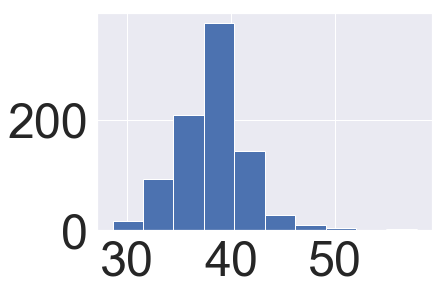

In [82]:
plt.hist(wrong_scores)



(array([0.00220224, 0.04148295, 0.09114564, 0.0453481 , 0.01341567,
        0.00516852, 0.00204493, 0.0008764 , 0.0017528 , 0.00141572]),
 array([29.32105446, 34.2026041 , 39.08415375, 43.96570339, 48.84725304,
        53.72880268, 58.61035233, 63.49190197, 68.37345161, 73.25500126,
        78.1365509 ]),
 <a list of 10 Patch objects>)

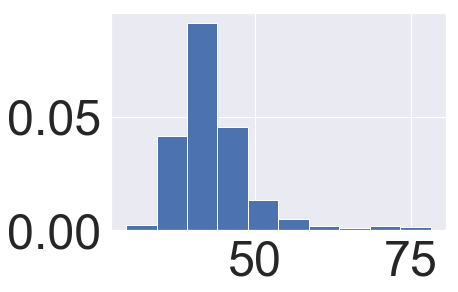

In [83]:
plt.hist(correct_scroes,density=True)

([array([0.00148345, 0.03031113, 0.09414384, 0.0492196 , 0.01503379,
         0.005336  , 0.00228053, 0.00088564, 0.001727  , 0.00141703]),
  array([0.01598265, 0.08927451, 0.08653462, 0.00844797, 0.00091329,
         0.00068497, 0.        , 0.        , 0.        , 0.        ])],
 array([28.59186935, 33.54633751, 38.50080566, 43.45527382, 48.40974197,
        53.36421013, 58.31867828, 63.27314644, 68.22761459, 73.18208275,
        78.1365509 ]),
 <a list of 2 Lists of Patches objects>)

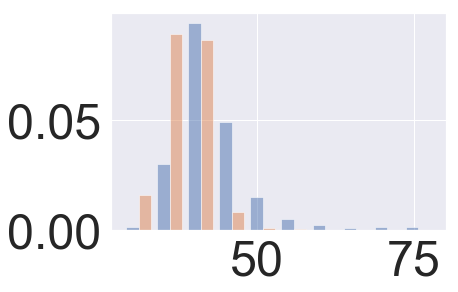

In [85]:
bins = [35,45,55,60,65,70]
plt.hist([correct_scroes,wrong_scores], 10, alpha=0.5, label=['correct','wrong'],density=True)
# plt.hist(wrong_scores, 10, alpha=0.5, label='wrong')

# plt.show()

In [86]:
# check unigrams intersection with other relations, both on tokens and entities
# on train as well
for d in result_per_type['voice type'][1]:
    show_set(d)
    print()
    

head: pamela dellal   ,   tail mezzo-soprano
voice type	 pamela dellal ( born 1960 ) is an American mezzo - soprano in opera and concert , a musicologist and academic teacher .

head: john ellis   ,   tail london
work location	 Paxton was visiting london in his capacity as a director of the Midland Railway to meet the chairman john ellis who was also a member of parliament . 0.00; 29.42
head: giorgio ronconi   ,   tail baritone
voice type	 giorgio ronconi ( 6 August 1810 – 8 January 1890 ) was an Italian operatic baritone celebrated for his brilliant acting and compelling stage presence .  1.00; 47.06
head: the nun   ,   tail denis diderot
after a work by	 La Religieuse ( the nun or " Memoirs of a Nun " ) is an 18th - century French novel by denis diderot .  0.00; 27.98
head: gulf war   ,   tail george bush
participant	 Greg Graffin said " During the gulf war , george bush said , ' We 'll win , because God is on our side ! ' .  0.00; 24.50
head: david kotey   ,   tail featherweight
com

head: eugenia tadolini   ,   tail soprano
voice type	 eugenia tadolini ( " née " Savorani ) ( 9 July 1809 – 11 July 1872 ) was an Italian operatic soprano . 1.00; 45.77
head: almaty region   ,   tail amandyk batalov
head of government	 amandyk batalov (; November 22 , 1952 ) is a Kazakh politician who is currently the Governor of almaty region since August 20 , 2014 .  0.00; 23.53
head: westlife   ,   tail sony music
record label	 In 2009 , he produced " Talk Me Down " for the Irish boy band westlife 's " Where We Are " album ( S / RCA / sony music .  0.00; 30.07
head: star citizen   ,   tail cloud imperium games
developer	 On March 19 , 2017 , cloud imperium games announced that " star citizen " would be using the Vulkan API instead of Direct3D.  0.00; 23.39
head: kantipur   ,   tail nepal
language of work or name	 He runs nepal 's largest selling daily " kantipur " as the Editor - in - Chief since 2008 .  0.00; 27.19


head: marcel lang   ,   tail tenor
voice type	 marcel lang ( June

In [87]:
def show_statson_all_relation(correct = 0):
    pred_acc = []
    scores_result = []
    std_result = [] 
    for k,v in result_per_type.items():
        scores_category = np.array(list(map(lambda x: x['scores'][int(x['prediction'])],v[correct])))
        pred_acc.append(len(v[1])/(len(v[0])+len(v[1]))*100)
        scores_result.append(scores_category.mean())
        std_result.append(scores_category.std())
        print(f"{k}:\t {scores_category.mean():.2f} +- {scores_category.std():.2f} ; {len(v[1])/(len(v[0])+len(v[1]))*100:.2f}%")
    #     print( k ,scores_category.mean(), "+-",scores_category.std(), " Acc is:", len(v[1])/(len(v[0])+len(v[1])))
    pred_acc = np.array(pred_acc)
    scores_result = np.array(scores_result)
    std_result = np.array(std_result)
#     X = np.stack((pred_acc,scores_result),axis=0)
#     print(np.cov(X))
#     print(np.corrcoef(np.stack((pred_acc,scores_result),axis=0)))
    return pred_acc,scores_result,std_result

In [88]:
pred_acc,scores_result_correct,std_result_correct = show_statson_all_relation(1)

country of origin:	 41.31 +- 1.67 ; 91.30%
owned by:	 36.88 +- 2.20 ; 73.73%
competition class:	 49.11 +- 3.70 ; 98.29%
instance of:	 43.83 +- 3.73 ; 99.20%
work location:	 40.54 +- 1.92 ; 94.74%
instrument:	 51.34 +- 5.94 ; 100.00%
military rank:	 42.86 +- 2.95 ; 96.72%
field of work:	 43.71 +- 4.40 ; 93.50%
country:	 41.75 +- 2.36 ; 92.06%
applies to jurisdiction:	 41.26 +- 3.91 ; 92.81%
performer:	 38.98 +- 2.17 ; 87.93%
characters:	 39.16 +- 1.01 ; 85.83%
original network:	 45.28 +- 3.19 ; 97.39%
located in the administrative territorial entity:	 40.87 +- 2.13 ; 94.53%
successful candidate:	 44.82 +- 2.89 ; 99.24%
publisher:	 39.99 +- 2.65 ; 90.76%
operator:	 38.75 +- 2.36 ; 88.14%
taxon rank:	 63.30 +- 8.90 ; 100.00%
residence:	 40.24 +- 1.66 ; 91.67%
notable work:	 41.24 +- 2.64 ; 90.48%
mother:	 39.80 +- 2.31 ; 75.38%
head of government:	 41.68 +- 2.65 ; 95.93%
located on terrain feature:	 42.14 +- 3.25 ; 89.05%
headquarters location:	 40.20 +- 1.95 ; 93.50%
sports season of lea

In [89]:
from scipy.stats import pearsonr

In [90]:
pearsonr(pred_acc,scores_result_correct)

(0.49996641632193, 2.3371743551327712e-06)

In [91]:
pred_acc,scores_result_wrong,std_result_wrong = show_statson_all_relation(0)

country of origin:	 42.02 +- 2.18 ; 91.30%
owned by:	 37.48 +- 2.64 ; 73.73%
competition class:	 36.84 +- 0.10 ; 98.29%
instance of:	 39.61 +- 0.00 ; 99.20%
work location:	 37.80 +- 2.62 ; 94.74%
instrument:	 nan +- nan ; 100.00%
military rank:	 37.13 +- 2.41 ; 96.72%
field of work:	 40.42 +- 2.36 ; 93.50%
country:	 38.98 +- 1.86 ; 92.06%
applies to jurisdiction:	 37.44 +- 2.53 ; 92.81%
performer:	 38.04 +- 1.38 ; 87.93%
characters:	 38.62 +- 1.27 ; 85.83%
original network:	 42.96 +- 4.17 ; 97.39%
located in the administrative territorial entity:	 39.42 +- 2.80 ; 94.53%
successful candidate:	 43.56 +- 0.00 ; 99.24%
publisher:	 38.96 +- 2.74 ; 90.76%
operator:	 36.56 +- 2.57 ; 88.14%
taxon rank:	 nan +- nan ; 100.00%
residence:	 40.24 +- 1.77 ; 91.67%
notable work:	 38.82 +- 1.40 ; 90.48%
mother:	 38.38 +- 2.67 ; 75.38%
head of government:	 39.37 +- 2.76 ; 95.93%
located on terrain feature:	 42.71 +- 3.01 ; 89.05%
headquarters location:	 37.01 +- 2.31 ; 93.50%
sports season of league or

/Users/ofersabo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/Users/ofersabo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ofersabo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ofersabo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ofersabo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ofersabo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff

In [92]:
pearsonr(pred_acc,scores_result_wrong)

(nan, 1.0)

In [93]:
scores_result_correct - scores_result_wrong

array([-7.06975680e-01, -5.98795791e-01,  1.22665785e+01,  4.21853884e+00,
        2.73690063e+00,             nan,  5.72550083e+00,  3.29096849e+00,
        2.77192503e+00,  3.82611043e+00,  9.41825391e-01,  5.39990183e-01,
        2.32366406e+00,  1.45582946e+00,  1.25929180e+00,  1.03425298e+00,
        2.19255147e+00,             nan, -1.14119348e-03,  2.41784572e+00,
        1.41290879e+00,  2.30601408e+00, -5.69826312e-01,  3.19236905e+00,
                   nan,  1.83909180e+00,  3.63445630e+00,  7.55922361e+00,
        5.03365065e+00,  1.06087606e+00,  4.24870099e+00,             nan,
        2.91373915e+00,  3.39915264e-01,  3.93449341e+00,  1.50343153e+00,
        8.76163453e-01,  1.81941040e-01,             nan,  3.27196807e+00,
                   nan,  2.29145829e+00,  4.28077781e+00,  8.51753593e+00,
        7.15567926e-01, -4.73784761e-01,  3.63254122e+00,  1.01303002e+00,
        1.95729373e+00,  3.23281497e+00,  3.85233324e-01,  3.44782282e+00,
        1.49849646e+00, -

In [94]:
print(pred_acc)

[ 91.30434783  73.72881356  98.29059829  99.2         94.73684211
 100.          96.72131148  93.49593496  92.06349206  92.8057554
  87.93103448  85.82677165  97.39130435  94.53125     99.24242424
  90.75630252  88.13559322 100.          91.66666667  90.47619048
  75.38461538  95.93495935  89.05109489  93.49593496 100.
  37.3015873   94.82758621  95.96774194  98.4         86.99186992
  76.06837607 100.          96.8503937   88.63636364  99.16666667
  99.16666667  94.7761194   96.74796748 100.          92.64705882
 100.          91.17647059  95.4887218   98.16513761  99.23664122
  86.13138686  88.23529412  81.18811881  89.70588235  96.11650485
  83.7398374   97.32142857  98.51851852  88.8         99.31506849
  95.58823529  96.61016949  95.58823529  92.91338583  99.31972789
  83.96946565  97.01492537  96.21212121  77.96610169  98.4
  67.61904762  96.92307692  71.30434783  85.03937008  89.83050847
  92.72727273  88.4057971   91.07142857  99.2481203   84.73282443
  41.46341463  94.01709402

In [99]:
from sklearn.metrics import confusion_matrix
mapping_rel_to_index = {}
for i,r in enumerate(result_per_type.keys()):
    mapping_rel_to_index[r] = i
labels = [x for x in result_per_type.keys()]
cm = confusion_matrix(gold_list, pred_list, labels)
print(cm)
lcm = [[np.log1p(x) for x in row] for row in cm ]

partial_lcm = [[x for x in row[:30]] for row in lcm[:30]]


[[126   0   0 ...   0   0   0]
 [  0  87   0 ...   0   0   0]
 [  0   0 115 ...   0   0   0]
 ...
 [  0   0   0 ... 125   0   0]
 [  0   0   0 ...   0 127   0]
 [  0   0   0 ...   0   0  95]]


[Text(0, 0.5, 'country '),
 Text(0, 1.5, 'owned by'),
 Text(0, 2.5, 'competit'),
 Text(0, 3.5, 'instance'),
 Text(0, 4.5, 'work loc'),
 Text(0, 5.5, 'instrume'),
 Text(0, 6.5, 'military'),
 Text(0, 7.5, 'field of'),
 Text(0, 8.5, 'country'),
 Text(0, 9.5, 'applies '),
 Text(0, 10.5, 'performe'),
 Text(0, 11.5, 'characte'),
 Text(0, 12.5, 'original'),
 Text(0, 13.5, 'located '),
 Text(0, 14.5, 'successf'),
 Text(0, 15.5, 'publishe'),
 Text(0, 16.5, 'operator'),
 Text(0, 17.5, 'taxon ra'),
 Text(0, 18.5, 'residenc'),
 Text(0, 19.5, 'notable '),
 Text(0, 20.5, 'mother'),
 Text(0, 21.5, 'head of '),
 Text(0, 22.5, 'located '),
 Text(0, 23.5, 'headquar'),
 Text(0, 24.5, 'sports s'),
 Text(0, 25.5, 'member o'),
 Text(0, 26.5, 'distribu'),
 Text(0, 27.5, 'movement'),
 Text(0, 28.5, 'particip'),
 Text(0, 29.5, 'sibling')]

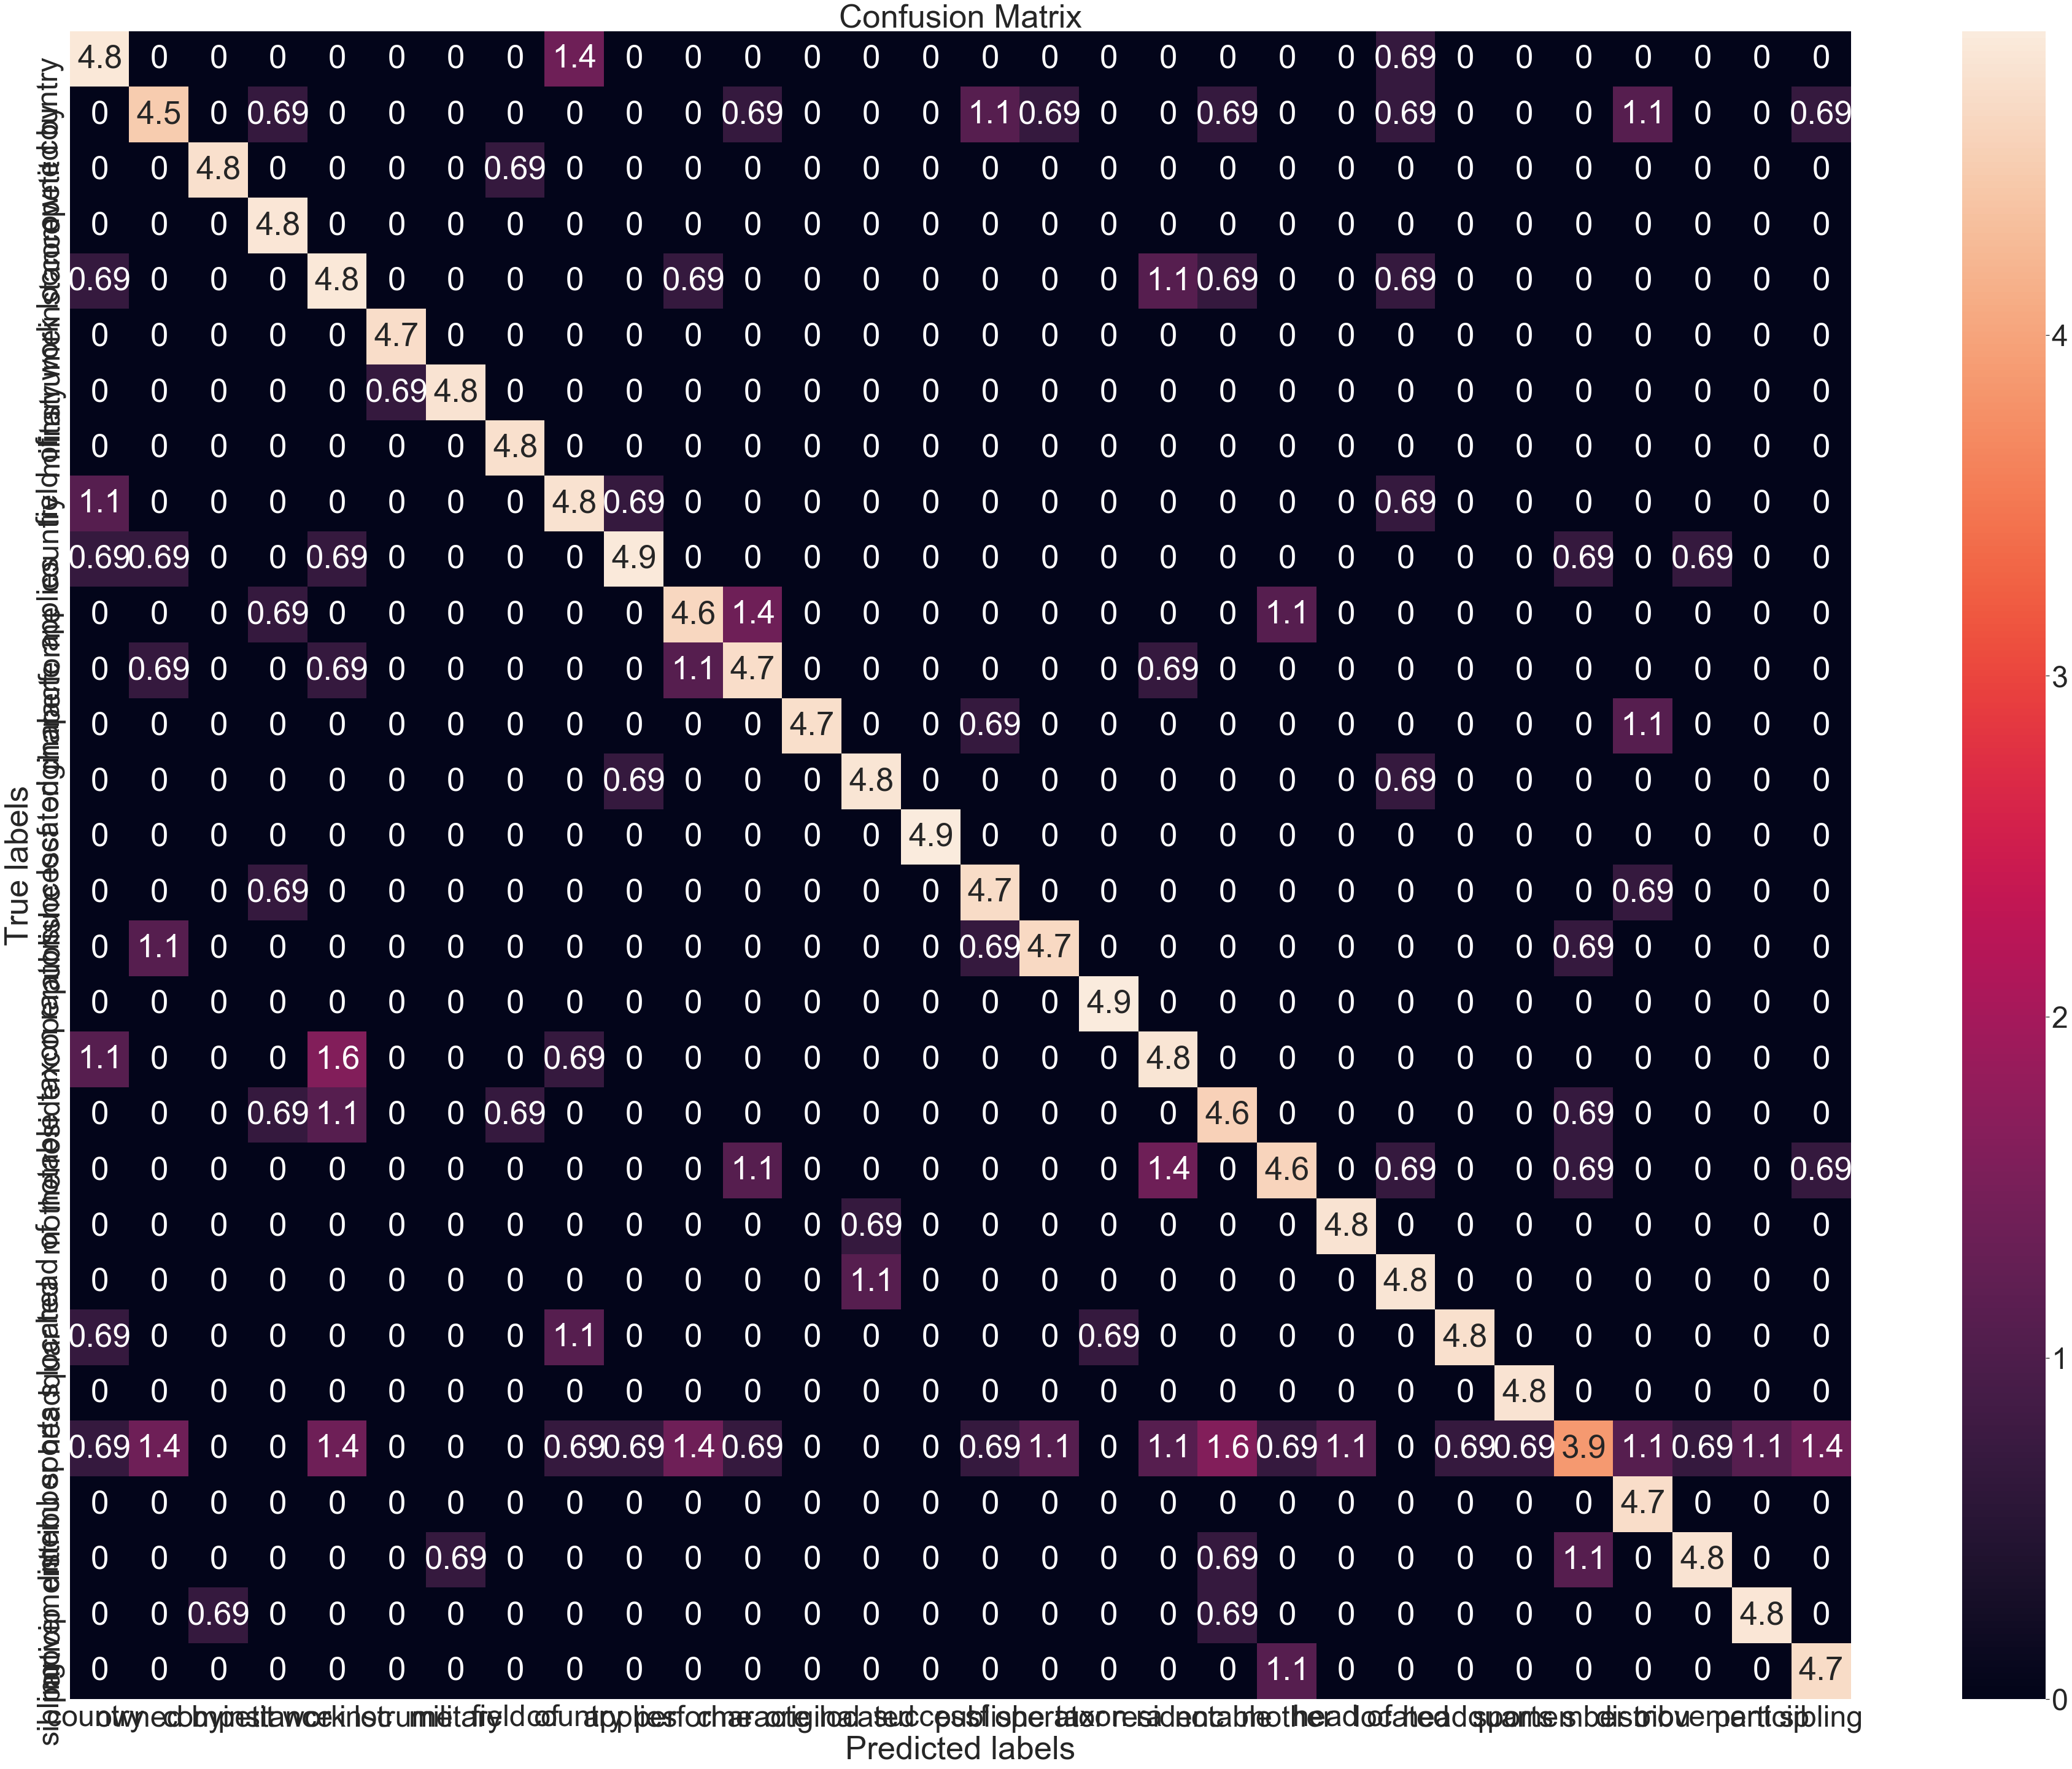

In [100]:
import seaborn as sns
 
fig = plt.figure(figsize=(65,50))
# ax = fig.add_subplot(111)
ax= plt.subplot()
sns.heatmap(partial_lcm, annot=True, ax = ax); #annot=True to annotate cells
sns.set(font_scale=4.4)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([x[:8] for x in result_per_type.keys()])
ax.yaxis.set_ticklabels([x[:8] for x in result_per_type.keys()])

In [97]:
this_dict = {}
for k,v in wrong_prediction_which_rel.items():
    this_dict[k] = [rel_type for rel_type,count in v.most_common()[:5]]
this_dict

{'owned by': ['occupant',
  'location',
  'manufacturer',
  'subsidiary',
  'constellation'],
 'original network': ['distributor', 'publisher'],
 'mother': ['father', 'residence', 'spouse', 'director', 'position held'],
 'member of': ['record label',
  'notable work',
  'child',
  'work location',
  'performer'],
 'characters': ['director',
  'after a work by',
  'performer',
  'participant',
  'said to be the same as'],
 'applies to jurisdiction': ['participant',
  'follows',
  'work location',
  'screenwriter',
  'manufacturer'],
 'located in or next to body of water': ['crosses',
  'located on terrain feature',
  'located in the administrative territorial entity',
  'country of origin',
  'country'],
 'country of citizenship': ['located in or next to body of water',
  'mountain range',
  'country',
  'instrument'],
 'located on terrain feature': ['crosses',
  'location',
  'located in the administrative territorial entity',
  'mountain range',
  'located in or next to body of water'